# Data Mining Techniques - Project 1
### Australian Sign Language Classification

### Imports

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from scipy.signal import medfilt
import itertools

### Parsing file names from the dataset

In [2]:
path = 'allsigns\\signs\\'
signers = os.listdir(path)
all_files = []
labels = []
for signer in signers:
    signs = os.listdir(path + signer)
    for sign in signs:
        all_files.append(path + signer + "\\" + sign)
        labels.append(sign.split('.')[0][:-1])

In [3]:
def vec_resize(vector, size = 50):
    """
        Expands/collapes a vector to a fixed size using down/oversampling.
    """
    current_size = len(vector)
    if current_size == size:
        return vector    
    if current_size > size:
        return [vector[_] for _ in sorted(random.sample(range(current_size), size))]
    else:
        return [vector[_] for _ in sorted(random.choices(range(current_size), k=size))]

In [4]:
def remove_white_noise(vector, thres = 0.01):
    """
        Removes values less than thres in the 
        signals (i.e white noise at beginning and end of recording.)
    """
    return [val for val in vector if abs(val) > thres]

In [5]:
#Mapping sign names to numerical indices.

label2ind = {label[1] : label[0] for label in enumerate(list(set(labels)))}

In [6]:
X = pd.DataFrame()

### Opening each sign file, parsing it, and performing white noise removal, vector resizing, and median filtering.

In [7]:
header = ['x', 'y', 'z', 'roll', 'pitch', 'yaw', 'thumb', 'fore', 'index', 'ring', 'little', 'keycode', 'gs1', 'gs2', 'rec']
cols_todrop = ['pitch', 'yaw', 'little', 'keycode', 'gs1', 'gs2', 'rec']
scaler = MinMaxScaler()
faulty_files = []

i=1
for sign_file in all_files:
    with open(sign_file) as csv_file:
        if i % 100 == 0:
            print('file', i, '/', len(all_files))
        i+=1
        try:
            df = pd.read_csv(csv_file)
            df.columns = header
            df = df.drop(cols_todrop, axis=1)

            x = medfilt(vec_resize(remove_white_noise(df['x'])))
            scaled_clean_x = scaler.fit_transform(x.reshape(-1, 1)).reshape(1,-1).flatten()


            y = medfilt(vec_resize(remove_white_noise(df['y'])))
            scaled_clean_y = scaler.fit_transform(y.reshape(-1, 1)).reshape(1,-1).flatten()

            # According to the dataset docs, Z is not accurate and has many zero values.
            # Therefore, we do not remove white noise for it
            z = medfilt(vec_resize(df['z']))
            scaled_clean_z = scaler.fit_transform(z.reshape(-1, 1)).reshape(1,-1).flatten()

            scaled_roll = medfilt(vec_resize(df['roll']))
            scaled_thumb = medfilt(vec_resize(df['thumb']))
            scaled_fore = medfilt(vec_resize(df['fore']))
            scaled_index = medfilt(vec_resize(df['index']))
            scaled_ring = medfilt(vec_resize(df['ring']))
            vals = {"x" : scaled_clean_x,
                    "y" : scaled_clean_y,
                    "z" : scaled_clean_z,
                    "roll": scaled_roll,
                    "thumb" : scaled_thumb,
                    "fore" : scaled_fore,
                    "index": scaled_index,
                    "ring" : scaled_ring}
            new_df = pd.DataFrame(vals)
            arrays = [list(new_df[col]) for col in new_df.columns]
            concat = list(itertools.chain(*arrays))
            concat_series = pd.Series(concat)
            X = X.append(concat_series, ignore_index=True)
        except:
            faulty_files.append(i)
            
            

file 100 / 6757
file 200 / 6757
file 300 / 6757
file 400 / 6757
file 500 / 6757
file 600 / 6757
file 700 / 6757
file 800 / 6757
file 900 / 6757
file 1000 / 6757
file 1100 / 6757
file 1200 / 6757
file 1300 / 6757
file 1400 / 6757
file 1500 / 6757
file 1600 / 6757
file 1700 / 6757
file 1800 / 6757
file 1900 / 6757
file 2000 / 6757
file 2100 / 6757
file 2200 / 6757
file 2300 / 6757
file 2400 / 6757
file 2500 / 6757
file 2600 / 6757
file 2700 / 6757
file 2800 / 6757
file 2900 / 6757
file 3000 / 6757
file 3100 / 6757
file 3200 / 6757
file 3300 / 6757
file 3400 / 6757
file 3500 / 6757
file 3600 / 6757
file 3700 / 6757
file 3800 / 6757
file 3900 / 6757
file 4000 / 6757
file 4100 / 6757
file 4200 / 6757
file 4300 / 6757
file 4400 / 6757
file 4500 / 6757
file 4600 / 6757
file 4700 / 6757
file 4800 / 6757
file 4900 / 6757
file 5000 / 6757
file 5100 / 6757
file 5200 / 6757
file 5300 / 6757
file 5400 / 6757
file 5500 / 6757
file 5600 / 6757
file 5700 / 6757
file 5800 / 6757
file 5900 / 6757
file 6

In [15]:
# Some files are empty, 
len(faulty_files)

5

In [16]:
len(labels)

6757

In [17]:
# Removing faulty files' indices
for fault in faulty_files:
    labels.pop(fault)

In [18]:
len(labels)

6752

In [19]:
len(X)

6752

### Creating X, y train and test sets:

In [20]:
y = [label2ind[label] for label in labels]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## Models
### Decision Tree using Gini Index:

**We perform 5-fold Cross-Validation with Grid Search to find the best regularization parameters.**

In [22]:
dtf_gini = DecisionTreeClassifier()

param_grid = [{"min_samples_leaf": [1, 3, 5], 'min_samples_split': [2, 3, 4]}]


grid_search_tree_gini = GridSearchCV(dtf_gini, param_grid, cv=5)
grid_search_tree_gini.fit(X_train, y_train)


C:\Users\ok\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid=[{'min_samples_leaf': [1, 3, 5],
                          'min_samples_split': [2, 3, 4]}],
             pre_di

In [24]:
# Best parameters determined from grid search and CV.
grid_search_tree_gini.best_params_

{'min_samples_leaf': 1, 'min_samples_split': 2}

In [25]:
# The training accuracy of the best model.
grid_search_tree_gini.best_score_

0.1683021662655064

In [36]:
# Fitting the best model to the data to find test accuracy.
tuned_dtf_gini = DecisionTreeClassifier(min_samples_leaf = grid_search_tree_gini.best_params_["min_samples_leaf"],
               min_samples_split = grid_search_tree_gini.best_params_["min_samples_split"])

tuned_dtf_gini.fit(X_train, y_train)
y_pred_tree_gini = tuned_dtf_gini.predict(X_test)

In [37]:
print("Accuracy of Gini DT:", accuracy_score(y_test, y_pred_tree_gini))

Accuracy of Gini DT: 0.19615099925980756


### Decision Tree using Gain Ratio (Entropy):

**We perform 5-fold Cross-Validation with Grid Search to find the best regularization parameters.**

In [28]:
dtf_ent = DecisionTreeClassifier(criterion = 'entropy')

param_grid = [{"min_samples_leaf": [1, 3, 5], 'min_samples_split': [2, 3, 4]}]


grid_search_tree_ent = GridSearchCV(dtf_ent, param_grid, cv=5)
grid_search_tree_ent.fit(X_train, y_train)

C:\Users\ok\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='entropy',
                                              max_depth=None, max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid=[{'min_samples_leaf': [1, 3, 5],
                          'min_samples_split': [2, 3, 4]}],
             pre

In [29]:
# Best parameters determined from grid search and CV.
grid_search_tree_ent.best_params_

{'min_samples_leaf': 5, 'min_samples_split': 2}

In [30]:
# The training accuracy of the best model.
grid_search_tree_ent.best_score_

0.17885576745047213

In [38]:
# Fitting the best model to the data to find test accuracy.
tuned_dtf_ent = DecisionTreeClassifier(min_samples_leaf = grid_search_tree_ent.best_params_["min_samples_leaf"],
               min_samples_split = grid_search_tree_ent.best_params_["min_samples_split"])

tuned_dtf_ent.fit(X_train, y_train)
y_pred_tree_ent = tuned_dtf_ent.predict(X_test)

In [39]:
print("Accuracy of Gain Ratio DT:", accuracy_score(y_test, y_pred_tree_ent))

Accuracy of Gain Ratio DT: 0.18060695780903036


### SVM:

**We perform 5-fold Cross-Validation with Grid Search to find the best regularization parameters and kernel.**

In [40]:
param_grid = [
        {'kernel': ['linear',"rbf"], 
         'C': [0.5, 1],
         "tol": [0.0001, 0.001]}]

clf = SVC()
grid_search_svm = GridSearchCV(clf, param_grid, cv=5)
grid_search_svm.fit(X_train, y_train)


C:\Users\ok\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ok\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ok\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [0.5, 1], 'kernel': ['linear', 'rbf'],
                          'tol': [0.0001, 0.001]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [41]:
# Best parameters determined from grid search and CV.
grid_search_svm.best_params_

{'C': 1, 'kernel': 'linear', 'tol': 0.0001}

In [42]:
# The training accuracy of the best model.
grid_search_svm.best_score_

0.4278837252360674

In [43]:
# Fitting the best model to the data to find test accuracy.
tuned_clf = SVC(kernel = grid_search_svm.best_params_["kernel"],
               C = grid_search_svm.best_params_["C"],
               tol = grid_search_svm.best_params_["tol"]) #recreating SVC with best params

tuned_clf.fit(X_train, y_train)
y_pred_svm = tuned_clf.predict(X_test)

In [44]:
print("Accuracy of SVM:", accuracy_score(y_test, y_pred_svm))

Accuracy of SVM: 0.42783123612139157


### Naive Bayes:

In [46]:
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)

y_pred_nb = nb_clf.predict(X_test)

In [47]:
print("Accuracy of Naive Bayes Classifier:", accuracy_score(y_test, y_pred_nb))

Accuracy of Naive Bayes Classifier: 0.20947446336047373


### 1-layer ANN:

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [412]:
EPOCHS = 20
BATCH_SIZE = 32
ATTRS = 400
HIDDEN_SIZE = ATTRS * 2
OUTPUT_SIZE = len(label2ind)
LEARNING_RATE = 3e-4

Creating batches iterator:

In [406]:
def get_batches(data, labels, batch_size):
    num_batches = len(data) // batch_size
    for i in range(0, num_batches*batch_size, batch_size):
        batch_rawX = torch.tensor(data[i:i+batch_size].to_numpy()).float()
        batch_rawY = torch.tensor(np.array(labels[i:i+batch_size]))
        yield batch_rawX, batch_rawY


Model initialization:

In [407]:
class FCANN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [416]:
net = FCANN(ATTRS, HIDDEN_SIZE, OUTPUT_SIZE)

In [431]:
print(net)

FCANN(
  (fc1): Linear(in_features=400, out_features=800, bias=True)
  (fc2): Linear(in_features=800, out_features=98, bias=True)
)


In [430]:
criterion = nn.CrossEntropyLoss()
optim = Adam(net.parameters(), lr = LEARNING_RATE)

Training the model:

In [418]:
def run(model, device, data, labels, criterion, optim):
    losses_total = []
    model.to(device)
    for e in range(EPOCHS):
        losses = []
        batches = get_batches(data, labels, BATCH_SIZE)
        for x, y in batches:            
            net.train()
            optim.zero_grad()
            scores = net.forward(x)
            loss = criterion(scores, y.long())
            losses.append(int(loss))
            loss.backward(retain_graph=True)
            loss.backward()
            _ = nn.utils.clip_grad_norm_(net.parameters(), 5)
            optim.step()
        losses_total.append(sum(losses)/len(losses))
        print(e+1, "/", EPOCHS)
    return losses_total
            

In [419]:
l = run(net, device, X_train, y_train, criterion, optim)

1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
20 / 20


Loss of the model per epoch:

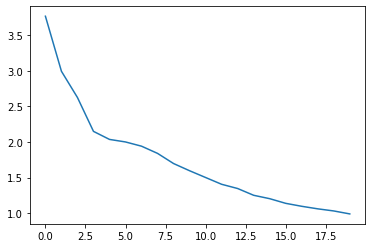

In [421]:
plt.plot(l)

### Testing ANN

In [428]:
with torch.no_grad():
    x = torch.tensor(X_test.to_numpy()).float()
    scores = net(x)
    _, predicted = torch.max(scores.data, 1)
    y_pred_ann = [int(label) for label in predicted]

In [429]:
print("Accuracy of ANN:", accuracy_score(y_test, y_pred_ann))

Accuracy of ANN: 0.4359733530717987
